In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras import backend as K
from tensorflow.python.framework import ops

In [2]:
ops.reset_default_graph()
%run tf_dnn_train_utils.py

In [3]:
x_data, y_data, features_df, label_df = load_data()
features_mean, features_std = features_df.mean(), features_df.std()
dims = x_data.shape[1]

loaded data
loaded features
loaded labels
prepared data


In [4]:
n_iters = 100
batch_size = 10000
alpha = 0.01
epsilon = 0.03
C = 200.0

In [5]:
def loss_custom(y_true, y_pred):

    epsilon_ = tf.constant([epsilon], name='epsilon', dtype=tf.float32)
    C_ = tf.constant([C], name='C',  dtype=tf.float32)

    unif_loss_scale = tf.ones_like(y_true[:,0], dtype=tf.float32)
    loss_scale0 = tf.to_float(tf.equal(y_true[:,1],0.0))
    loss_scale2 = tf.to_float(tf.maximum(tf.abs(y_true[:,2]),1.0))

    loss = svr_loss(y_true[:,0], y_pred[:,0], loss_scale0, epsilon_, C_*0.5)

    loss += svr_loss(y_true[:,0], y_pred[:,0], loss_scale2, epsilon_, C_*0.3)

    y_targetc = (2*tf.to_float(tf.not_equal(y_true[:,1],0.0)) - 1.0)
    loss += svc_loss(y_targetc, y_pred[:,0], loss_scale2, clip, C_*0.15)

    labelc = tf.sign(y_true[:,0])
    loss += svc_sign_loss(labelc, y_pred[:,0], loss_scale2, C_*0.25)
        
    return loss
    
def rmse(y_true, y_pred):
    rmse_ = K.sqrt(K.mean(K.square(y_true[:,0] - y_pred[:,0]),[-1]))
    return rmse_

def mae(y_true, y_pred):
    mae_ = K.mean(K.abs(y_true[:,0] - y_pred[:,0]),[-1])
    return mae_

def mmc(y_true, y_pred):
    mmc_ = tf.reduce_mean(tf.to_float(tf.equal(tf.to_float(tf.greater_equal(tf.abs(y_pred[:,0]),clip)) , y_true[:,1])))
    return mmc_

def msc(y_true, y_pred):
    msc_ = tf.reduce_mean(tf.to_float(tf.equal(tf.sign(y_true[:,0]), tf.sign(y_pred[:,0]))), [-1])
    return msc_

In [79]:
model = tf.keras.Sequential([
# layers.Input(shape=(543,)),
# layers.Dropout(0.1),
layers.Dense(128, activation='relu', input_shape=(543,), kernel_regularizer=regularizers.l1(0.05)),#,activity_regularizer=regularizers.l1(0.01)),
layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.05)),#,activity_regularizer=regularizers.l1(0.01)),
layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.05)),#,activity_regularizer=regularizers.l1(0.01)),
layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),#,activity_regularizer=regularizers.l1(0.01)),
layers.Dense(3, activation='linear', kernel_regularizer=regularizers.l2(0.01))])#,activity_regularizer=regularizers.l1(0.01))])


model.compile(optimizer=tf.train.AdamOptimizer(0.0005),
              loss=loss_custom,
              metrics=[rmse, mae, mmc,msc])

In [14]:
# model = tf.keras.Sequential([
# layers.Dense(128, activation='relu', input_shape=(543,), kernel_regularizer=regularizers.l2(0.01)),#,activity_regularizer=regularizers.l1(0.01)),
# layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),#,activity_regularizer=regularizers.l1(0.01)),
# layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),#,activity_regularizer=regularizers.l1(0.01)),
# layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),#,activity_regularizer=regularizers.l1(0.01)),
# layers.Dense(3, activation='linear', kernel_regularizer=regularizers.l2(0.01))])#,activity_regularizer=regularizers.l1(0.01))])

model = tf.keras.models.load_model('../../model/dnn_rel5d.h5')

model.compile(optimizer=tf.train.AdamOptimizer(0.0001),
              loss=loss_custom,
              metrics=[rmse, mae, mmc,msc])

In [18]:
train_dataset, train_iterator = get_dataset_iter("../../data/train/features.tfr",n_iters, batch_size)
test_dataset, test_iterator = get_dataset_iter("../../data/test/features.tfr",n_iters, batch_size)

model.fit(train_dataset, epochs=10, steps_per_epoch=100, shuffle=True, validation_data=test_dataset, validation_steps=10)

Epoch 1/10
100/100 [==============================] - 68s 680ms/step - loss: 1524.6663 - rmse: 7.2280 - mae: 3.6626 - mmc: 0.8574 - msc: 0.8961 - val_loss: 1535.1869 - val_rmse: 7.3488 - val_mae: 3.7521 - val_mmc: 0.8585 - val_msc: 0.8911
Epoch 2/10
100/100 [==============================] - 68s 679ms/step - loss: 1531.1553 - rmse: 7.2766 - mae: 3.6844 - mmc: 0.8560 - msc: 0.8976 - val_loss: 1579.8372 - val_rmse: 7.4357 - val_mae: 3.7555 - val_mmc: 0.8486 - val_msc: 0.8948
Epoch 3/10
100/100 [==============================] - 69s 691ms/step - loss: 1528.2558 - rmse: 7.2432 - mae: 3.6746 - mmc: 0.8562 - msc: 0.8978 - val_loss: 1550.1380 - val_rmse: 7.3616 - val_mae: 3.7412 - val_mmc: 0.8568 - val_msc: 0.8939
Epoch 4/10
100/100 [==============================] - 68s 684ms/step - loss: 1532.7632 - rmse: 7.3069 - mae: 3.7006 - mmc: 0.8565 - msc: 0.8967 - val_loss: 1583.8732 - val_rmse: 7.5080 - val_mae: 3.8618 - val_mmc: 0.8582 - val_msc: 0.8875
Epoch 5/10
100/100 [========================

In [19]:
model.save('../../model/dnn_rel5d.h5')

In [69]:
bmodel = tf.keras.Sequential([
layers.Dense(128, activation='relu', input_shape=(543,), kernel_regularizer=regularizers.l2(0.01)),#,activity_regularizer=regularizers.l1(0.01)),
layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),#,activity_regularizer=regularizers.l1(0.01)),
layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),#,activity_regularizer=regularizers.l1(0.01)),
layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),#,activity_regularizer=regularizers.l1(0.01)),
layers.Dense(3, activation='linear', kernel_regularizer=regularizers.l2(0.01))])#,activity_regularizer=regularizers.l1(0.01))])

bmodel.compile(optimizer=tf.train.AdamOptimizer(0.0001),
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

In [ ]:
bmodel.fit(train_dataset, epochs=10, steps_per_epoch=100, shuffle=False)

In [20]:
ypred_data = model.predict(x_data)[:,0]

In [18]:
ypred_data = bmodel.predict(x_data)[:,0]

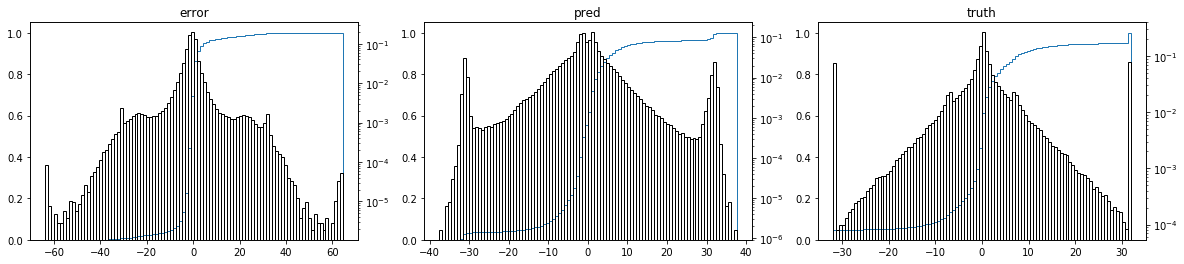

In [50]:
def cumdistplot(vec, ax, title):
    ax.hist(vec, bins=100, density=True, log=False, cumulative=True, fill=False,histtype='step')
    ax.twinx().hist(vec, bins=100, density=True, log=True, cumulative=False, fill=False,histtype='bar')
    ax.set_title(title)

fig, axes = plt.subplots(1,3, figsize=(20,4))
cumdistplot(ypred_data-y_data[:,0], axes[0], 'error')
cumdistplot(ypred_data, axes[1],'pred')
cumdistplot(y_data[:,0], axes[2], 'truth')

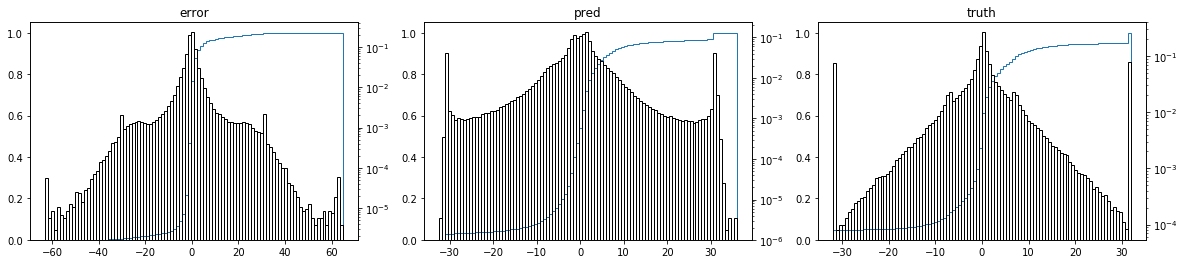

In [25]:
def cumdistplot(vec, ax, title):
    ax.hist(vec, bins=100, density=True, log=False, cumulative=True, fill=False,histtype='step')
    ax.twinx().hist(vec, bins=100, density=True, log=True, cumulative=False, fill=False,histtype='bar')
    ax.set_title(title)

fig, axes = plt.subplots(1,3, figsize=(20,4))
cumdistplot(ypred_data-y_data[:,0], axes[0], 'error')
cumdistplot(ypred_data, axes[1],'pred')
cumdistplot(y_data[:,0], axes[2], 'truth')

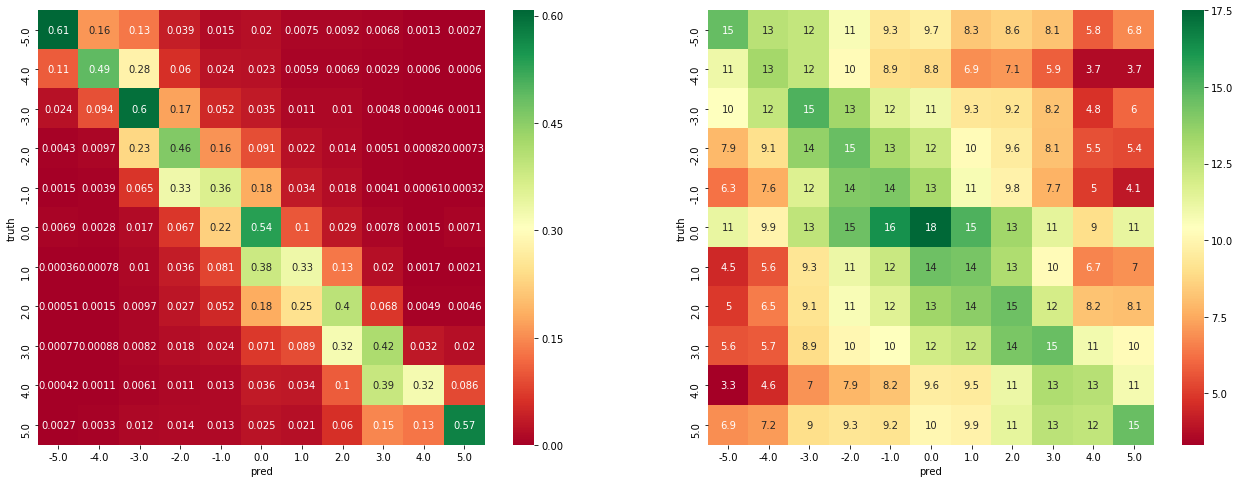

In [52]:
predl2 = np.clip(np.round(np.sign(ypred_data)*np.log2(np.maximum(np.abs(ypred_data),1))),-l2clip,l2clip)
yl2 = np.round(y_data[:,2])
l2_conf_mat = pd.crosstab(yl2, predl2, rownames=['truth'],colnames=['pred'])
l2_conf_mat_norm = l2_conf_mat.T.div(l2_conf_mat.sum(axis=1).astype(np.float32)).T
fig, ax = plt.subplots(1,2,figsize=(22,8))
sns.heatmap(l2_conf_mat_norm,ax=ax[0],annot=True, cmap="RdYlGn")
sns.heatmap(np.log2(l2_conf_mat+1),ax=ax[1],annot=True, cmap="RdYlGn")

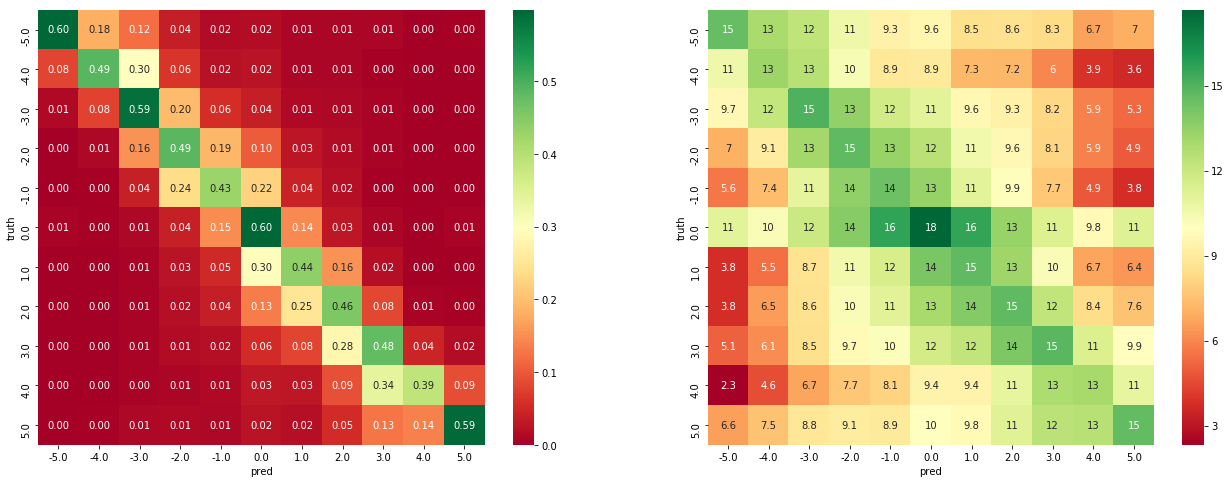

In [22]:
predl2 = np.clip(np.round(np.sign(ypred_data)*np.log2(np.maximum(np.abs(ypred_data),1))),-l2clip,l2clip)
yl2 = np.round(y_data[:,2])
l2_conf_mat = pd.crosstab(yl2, predl2, rownames=['truth'],colnames=['pred'])
l2_conf_mat_norm = l2_conf_mat.T.div(l2_conf_mat.sum(axis=1).astype(np.float32)).T
fig, ax = plt.subplots(1,2,figsize=(22,8))
sns.heatmap(l2_conf_mat_norm,ax=ax[0],annot=True, fmt='.2f', cmap="RdYlGn")
sns.heatmap(np.log2(l2_conf_mat+1),ax=ax[1],annot=True, cmap="RdYlGn")

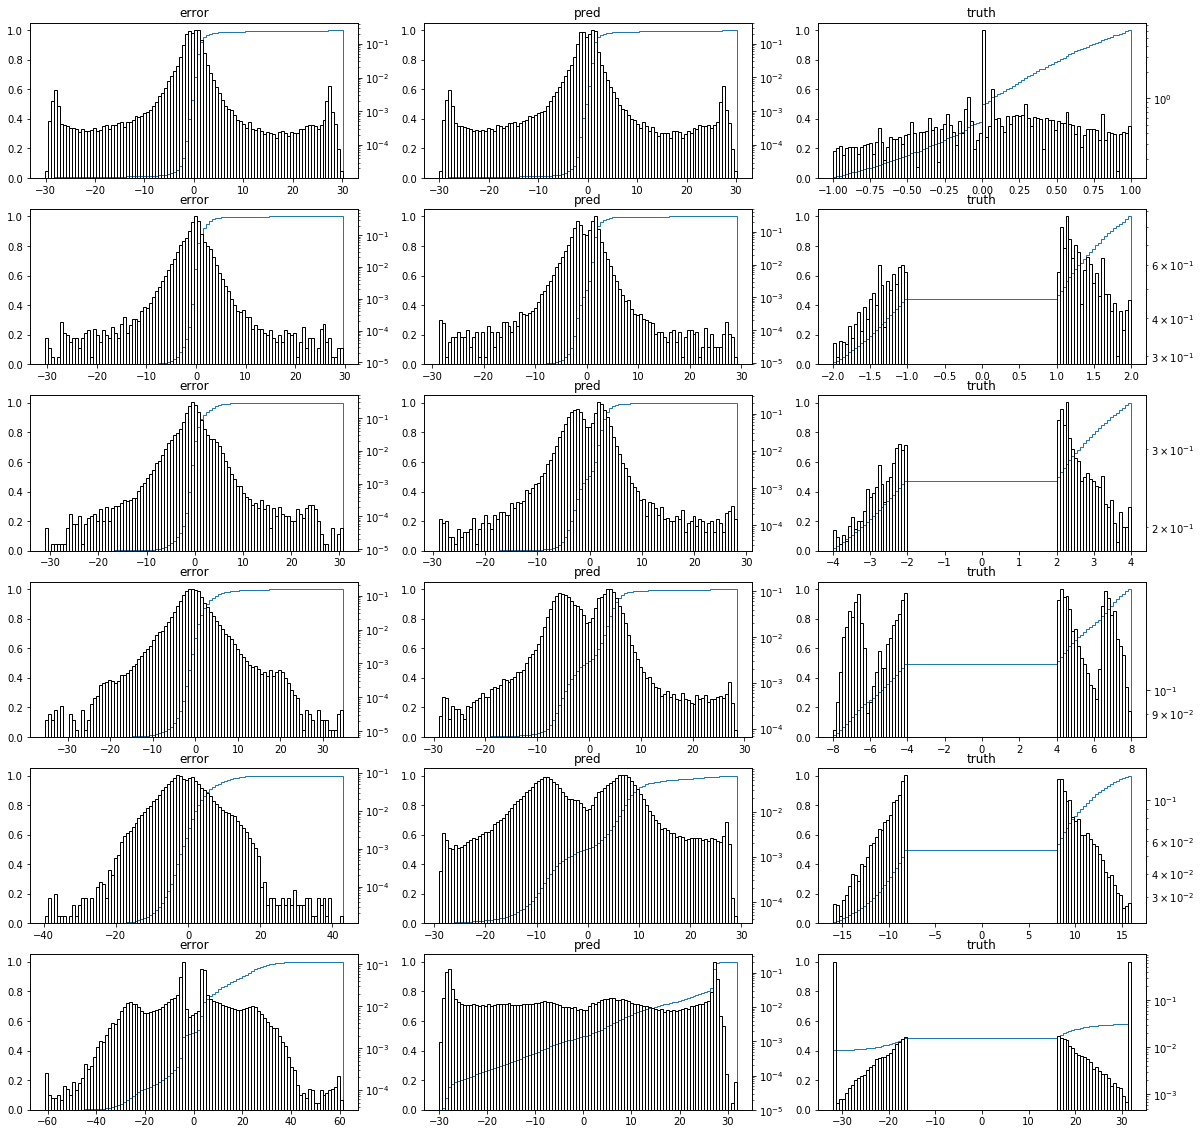

In [37]:
fig, axes = plt.subplots(6, 3, figsize=(20,20))
for index in range(6):
    mask = np.ceil(np.abs(y_data[:,2])) == index
    pred = ypred_data[mask]
    pred = np.clip(pred, -clip, clip)
    
    truth =  y_data[mask,0]
    err = pred - truth
    cumdistplot(err, axes[index][0],'error')
    cumdistplot(pred, axes[index][1],'pred')
    cumdistplot(truth, axes[index][2],'truth')
    
a0=1

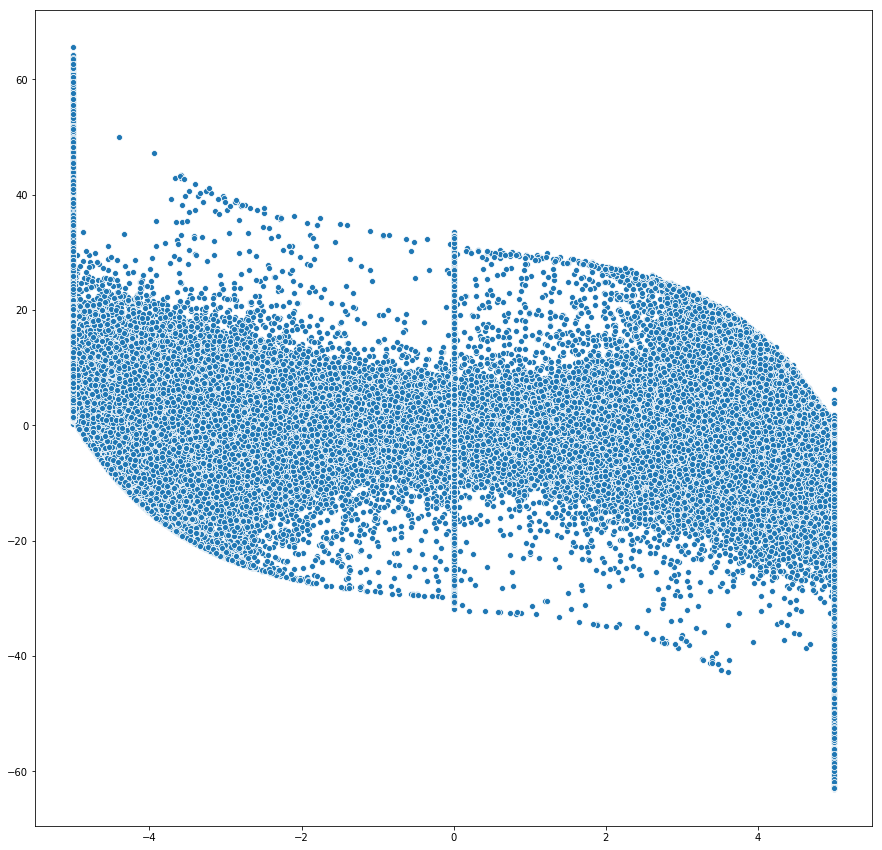

In [12]:
fig, ax = plt.subplots(figsize=(15,15))
sns.scatterplot(y_data[:,2],ypred_data - y_data[:,0], ax=ax)

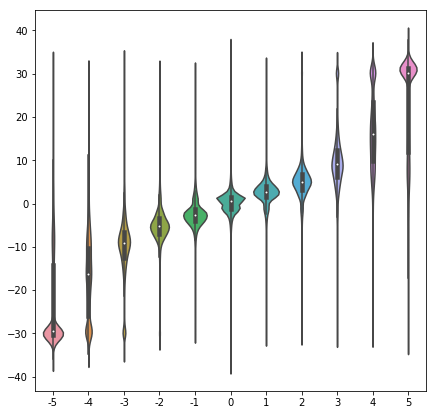

In [18]:
fig, ax = plt.subplots(figsize=(7,7))
sns.violinplot(y_data[:,2].astype(np.int),ypred_data, ax=ax)

In [26]:
def save_dnn(reg, filename):
    layer0 = pd.DataFrame(reg[0][0], index=feature_names)
    f = open(filename,"w")
    layer0.to_csv(f,header=False, float_format='%.12f')
    f.close()
    f = open(filename,"a+")
    f.write("\n")
    f.write(" ".join(map(str,reg[0][1].shape)))
    f.write("\n")
    np.savetxt(f, reg[0][1].astype('float32'), delimiter=",")
    f.write("\n")
    n_coefs = len(reg)
    f.write(str(n_coefs-2))
    f.write("\n")        
    for i in range(1,n_coefs):
        f.write(" ".join(map(str,reg[i][0].shape)))
        f.write("\n")
        np.savetxt(f, reg[i][0].astype('float32'), delimiter=",")
        f.write("\n")
        f.write(" ".join(map(str,reg[i][1].shape)))
        f.write("\n")
        np.savetxt(f, reg[i][1].astype('float32'), delimiter=",")
        f.write("\n")
    f.close()    

In [27]:
model_params = [ layer.get_weights() for layer in model.layers if layer.get_weights()]
model_params[-1][0] = model_params[-1][0][:,0][:,np.newaxis]
model_params[-1][1] = np.array([model_params[-1][1][0]])
save_dnn(model_params, "../../model/dnn_relud.txt")

In [28]:
np.mean(np.abs(ypred_data-y_data[:,0]))

2.9889323947016866

In [29]:
model_params = [ layer.get_weights() for layer in model.layers if layer.get_weights()]

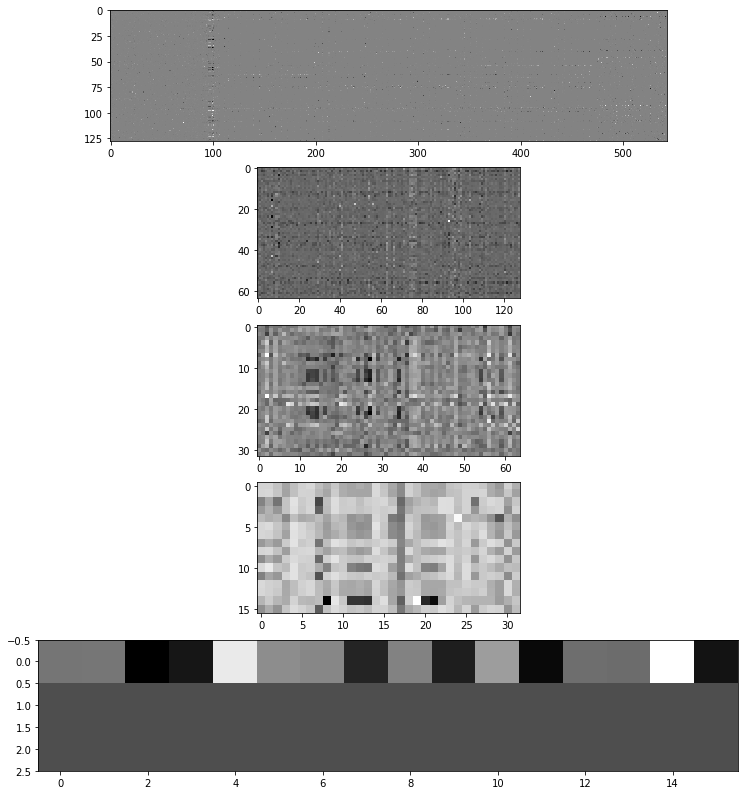

In [30]:
fig, axes = plt.subplots(len(model_params), figsize=(20,14))
for index, model_param in enumerate(model_params):
    axes[index].imshow(model_param[0].T,cmap='gray')

In [80]:
for i in range(len(model_params)):
    model.layers[i].set_weights(model_params[i])